In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def plot_correlations(df, figsize=(11,9)):
    corr = df.to_returns().dropna().corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm')

In [4]:
def plot_df(df, figsize=(12,9), title="", legend_loc="best", legend_ordered=True, logy=True):
    columns = df.iloc[-1].sort_values(ascending=False).index #마지막값 높은 순서로
    # print(columns)
    df = df[columns] # 데이터프레임 열 순서를 변경
    ax = df.plot(figsize=(12,8), title=title, logy=logy)
    leg = ax.legend(loc=legend_loc)
    if legend_ordered:
        for line, text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color()) # 범례의 글씨 색깔을 범례와 동일하게

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [5]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
prices.isna().sum()
prices.info()

MKF500      0
에너지         0
화학          0
금속및광물       0
기타 소재       0
건설          0
조선          0
기타자본재       0
상업서비스       0
운송          0
자동차및부품      0
내구소비재및의류    0
소비자서비스      0
미디어         0
유통          0
음식료및담배      0
생활용품        0
의료          0
은행          0
보험          0
증권          0
기타금융        0
소프트웨어       0
하드웨어        0
반도체         0
디스플레이       0
통신서비스       0
유틸리티        0
코스피200      0
코스닥         0
달러          0
나스닥100      0
다우          0
현금          0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7122 entries, 2001-01-02 to 2020-07-02
Data columns (total 34 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MKF500    7122 non-null   int64  
 1   에너지       7122 non-null   int64  
 2   화학        7122 non-null   int64  
 3   금속및광물     7122 non-null   int64  
 4   기타 소재     7122 non-null   int64  
 5   건설        7122 non-null   int64  
 6   조선        7122 non-null   int64  
 7   기타자본재     7122 non-null   int64  
 8   상업서비스     7122 non-null   int64  
 9   운송        7122 non-null   int64  
 10  자동차및부품    7122 non-null   int64  
 11  내구소비재및의류  7122 non-null   int64  
 12  소비자서비스    7122 non-null   int64  
 13  미디어       7122 non-null   int64  
 14  유통        7122 non-null   int64  
 15  음식료및담배    7122 non-null   int64  
 16  생활용품      7122 non-null   int64  
 17  의료        7122 non-null   int64  
 18  은행        7122 non-null   int64  
 19  보험        7122 non-null   int64  
 20  증권        71

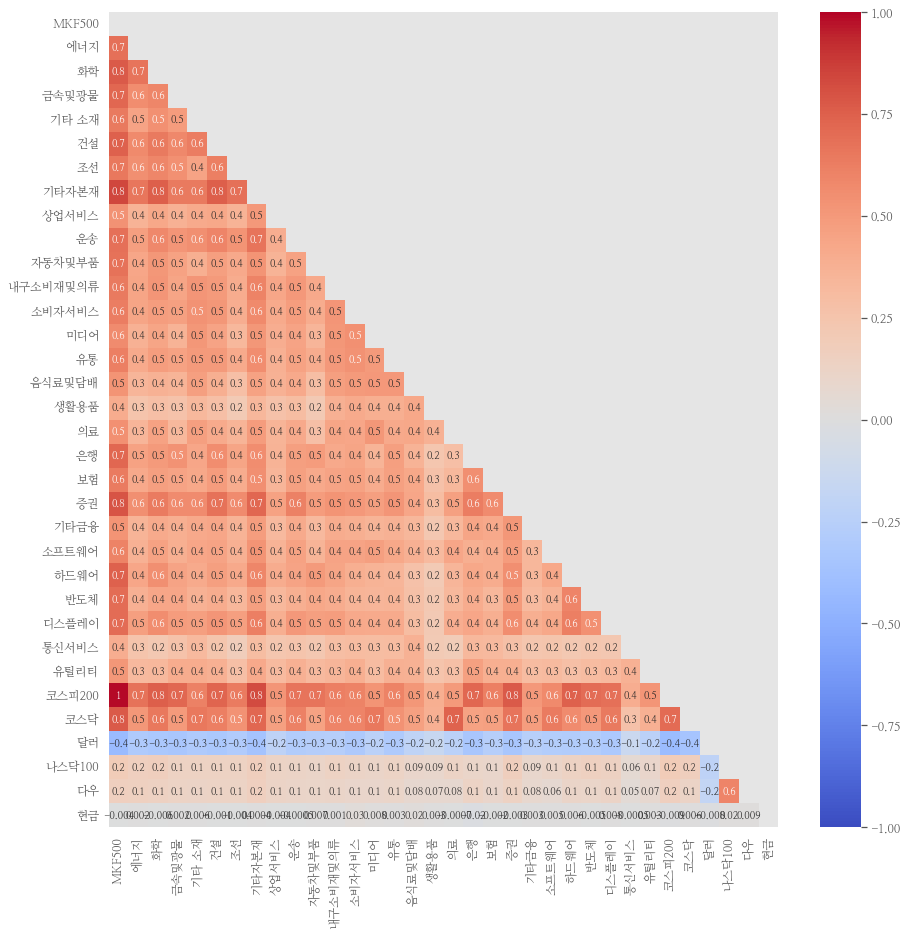

In [6]:
plot_correlations(prices, figsize=(15, 15))

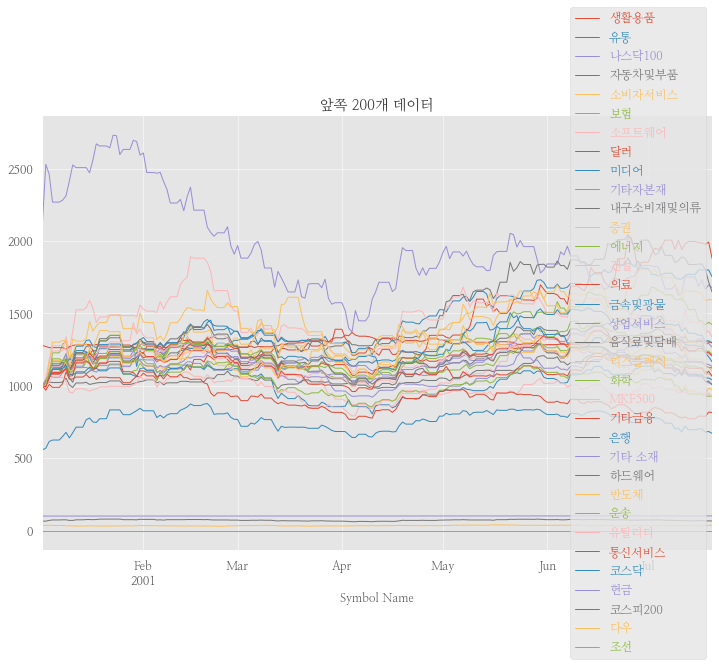

In [7]:
# 앞쪽 데이터를 찍어서 정상성을 확인해본다.
# 조선이 0값이 들어 있다.
# 조선 2004-06-14 부터 데이터 있음 이전에는 0으로 채워져 있음..NaN으로 채워야 하지 않나?
plot_df(prices[:200], title="앞쪽 200개 데이터", legend_loc="center right", legend_ordered=True, logy=False)

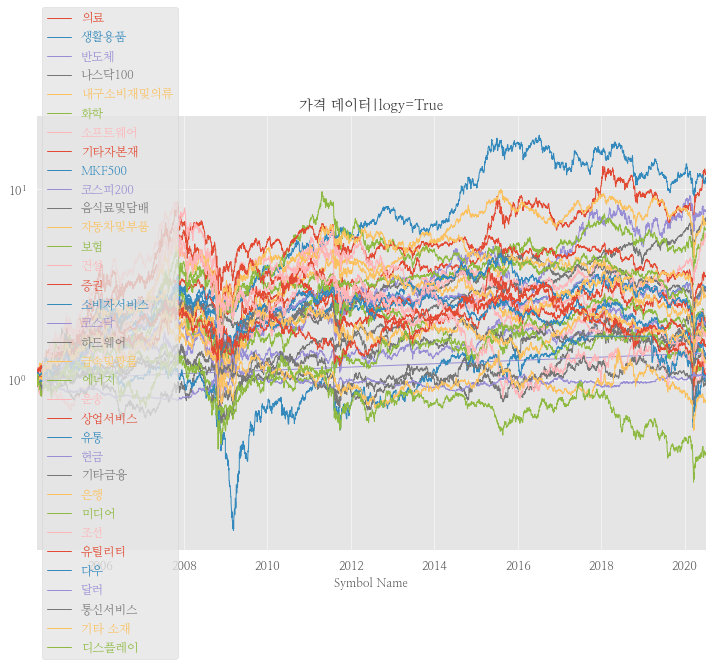

In [8]:
# 조선은 rebase시 Inf라 실제 그려지지 않는다.
t = prices.loc[prices['조선'] != 0].rebase(1)
plot_df(t, title="가격 데이터|logy=True", legend_loc="center left", legend_ordered=True)

## 한국 1. ID상대모멘텀
- **유니버스**
    - fnguide 섹터 인덱스
- **백테스팅 조건**
    - 섹터 인덱스의 6, 9, 12개월 수익률 평균값과 ID(직전 12개월의 월간 정보이산성)의 곱으로 상위 1개 섹터 선별
    - OECD 선행지표 (2개월 후행) 전월비 상승시 베팅, 하락시 현금 보유
- **월간 리밸런싱**

In [9]:
pdf = prices[:400].copy() # 백테스팅 디버깅을 위해 적은 데이터를 생성

In [10]:
# 백테스팅을 위한 전략 클래스 작성
class StatIDMomentumScore(bt.Algo):
    def __init__(self, lookback=pd.DateOffset(years=2), #FIXME : 12개월이되어야 하지만 원 알고리즘을 테스트한다.
                 lag=pd.DateOffset(months=1)):
        super(StatIDMomentumScore, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
        selected = target.temp['selected']
        t0 = target.now - self.lag
        # prc = target.universe.loc[(t0 - self.lookback):t0,selected] # FIXME 12개월치의 데이터를 뽑는다.
        prc = target.universe.loc[t0-self.lookback:t0,selected]
        # print(t0, prc.iloc[-365:-30])
        #6, 9, 12개월 평균모멘텀스코어
        # print(prc.iloc[-183:-30])
        
        #2002.2.1 -> 2002.1.2 -> 2001.8.3 -> 2001.5.4 -> 2001.2.1
        #백테트.py와 맞춘 수익률
        m6_returns = (prc.iloc[-183:-30].calc_total_return()+1) # 1달제외 6개월 수익률 (현재 prices가 공휴일포함 데이터임)
        m9_returns = (prc.iloc[-274:-30].calc_total_return()+1) # 1달제외 9개월 수익률
        m12_returns = (prc.iloc[-366:-30].calc_total_return()+1)  # 1달제외 12개월 수익률
        average_returns = (m6_returns+m9_returns+m12_returns)/3
        # print(f"{t0}\n===average_returns : \n{average_returns}\n")
        
        # ID 계산 최근 30일 제외
        # dropna에 주의 해야 한다. 조선이 0이 있어 문제가 되므로 모든 column이 nan일 때만 drop한다.
        # print(prc[-(365+30):])
        #print(f"{t0} len {len(prc[-(366+30):].pct_change(30).dropna(how='all'))}")
        pos_percent = np.where(prc[-(366+30):].pct_change(30).dropna(how='all') > 0.0, 1, 0).mean(axis=0)
        neg_percent = 1 - pos_percent
        ID = (neg_percent - pos_percent)
        # print(f"ID===\n{ID}")

        target.temp['stat'] = average_returns * ID * -1
        return True

In [11]:
def bt_SectorIDMomentum(name, n, tickers, prices):
    st = bt.Strategy(name,
                      algos = [
                          bt.algos.RunAfterDate('2002-1-2'),
                          bt.algos.RunMonthly(),
                          bt.algos.SelectAll(),
                          bt.algos.SelectThese(tickers),
                          StatIDMomentumScore(lag=pd.DateOffset(days=0)),
                          bt.algos.SelectN(n=n, sort_descending=True),
                          # bt.algos.PrintDate(),
                          bt.algos.WeighEqually(),
                          # bt.algos.PrintTempData(),
                          bt.algos.Rebalance()
                      ],
                     )
    return bt.Backtest(st, prices)

In [12]:
tickers = list(prices.columns[:-4])#+['현금']
bt_id1 = bt_SectorIDMomentum("base1.ID상대모멘텀", n=1, tickers=tickers, prices=prices)
bt_id2 = bt_SectorIDMomentum("base2.ID상대모멘텀", n=2, tickers=tickers, prices=prices)
bt_id3 = bt_SectorIDMomentum("base3.ID상대모멘텀", n=3, tickers=tickers, prices=prices)

In [13]:
r = bt.run(bt_id1, bt_id2, bt_id3)

In [14]:
r.set_date_range("2002-02-01")
r.display()

Stat                 base1.ID상대모멘텀    base2.ID상대모멘텀    base3.ID상대모멘텀
-------------------  --------------------  --------------------  --------------------
Start                2002-02-01            2002-02-01            2002-02-01
End                  2020-07-02            2020-07-02            2020-07-02
Risk-free rate       0.00%                 0.00%                 0.00%

Total Return         1682.11%              794.20%               884.07%
Daily Sharpe         0.52                  0.47                  0.51
Daily Sortino        0.82                  0.72                  0.78
CAGR                 16.93%                12.63%                13.22%
Max Drawdown         -69.87%               -63.15%               -60.86%
Calmar Ratio         0.24                  0.20                  0.22

MTD                  4.87%                 1.93%                 2.32%
3m                   51.31%                32.70%                26.46%
6m                   48.79%                20.23%

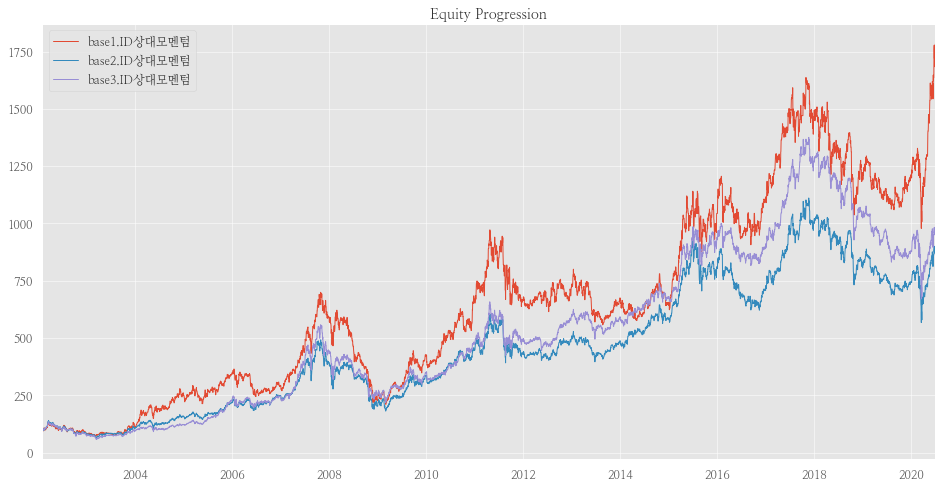

In [15]:
_=r.plot(figsize=(16,8))

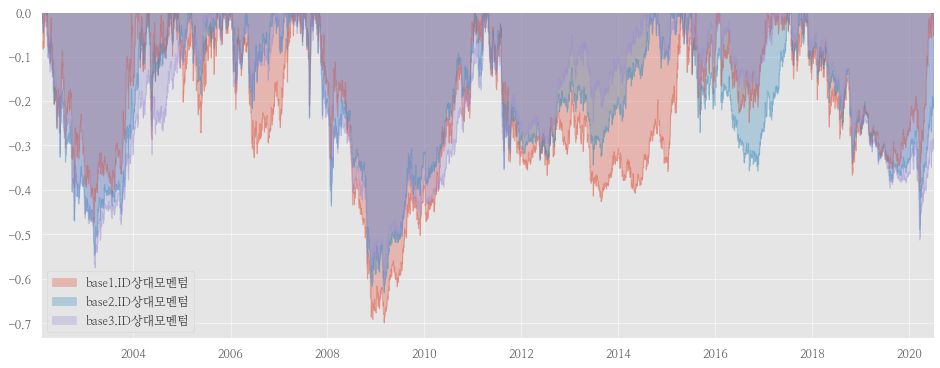

In [16]:
_=r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6))

## ticker에 현금을 추가

현금을 하나의 자산(?)으로 보고 모멘텀을 같이 계산한다.

In [17]:
tickers = list(prices.columns[:-4])+['현금']
bt_id1_cash = bt_SectorIDMomentum("base1.ID상대모멘텀(현금포함)", n=1, tickers=tickers, prices=prices)
bt_id2_cash = bt_SectorIDMomentum("base2.ID상대모멘텀(현금포함)", n=2, tickers=tickers, prices=prices)
bt_id3_cash = bt_SectorIDMomentum("base3.ID상대모멘텀(현금포함)", n=3, tickers=tickers, prices=prices)

In [18]:
r2 = bt.run(bt_id1_cash, bt_id2_cash, bt_id3_cash)

In [19]:
r_all = bt.run(bt_id1, bt_id2, bt_id3, bt_id1_cash, bt_id2_cash, bt_id3_cash)

In [21]:
r_all.set_date_range("2002-02-01")
r_all.stats

,base1.ID상대모멘텀,base2.ID상대모멘텀,base3.ID상대모멘텀,base1.ID상대모멘텀(현금포함),base2.ID상대모멘텀(현금포함),base3.ID상대모멘텀(현금포함)
start,2002-02-01 00:00:00,2002-02-01 00:00:00,2002-02-01 00:00:00,2002-02-01 00:00:00,2002-02-01 00:00:00,2002-02-01 00:00:00
end,2020-07-02 00:00:00,2020-07-02 00:00:00,2020-07-02 00:00:00,2020-07-02 00:00:00,2020-07-02 00:00:00,2020-07-02 00:00:00
rf,0.000,0.000,0.000,0.000,0.000,0.000
total_return,16.821,7.942,8.841,1.648,5.230,4.416
cagr,0.169,0.126,0.132,0.054,0.104,0.096
max_drawdown,-0.699,-0.631,-0.609,-0.352,-0.501,-0.507
calmar,0.242,0.200,0.217,0.154,0.208,0.189
mtd,0.049,0.019,0.023,0.000,0.024,0.013
three_month,0.513,0.327,0.265,0.005,0.244,0.214
six_month,0.488,0.202,0.123,0.010,0.238,0.141


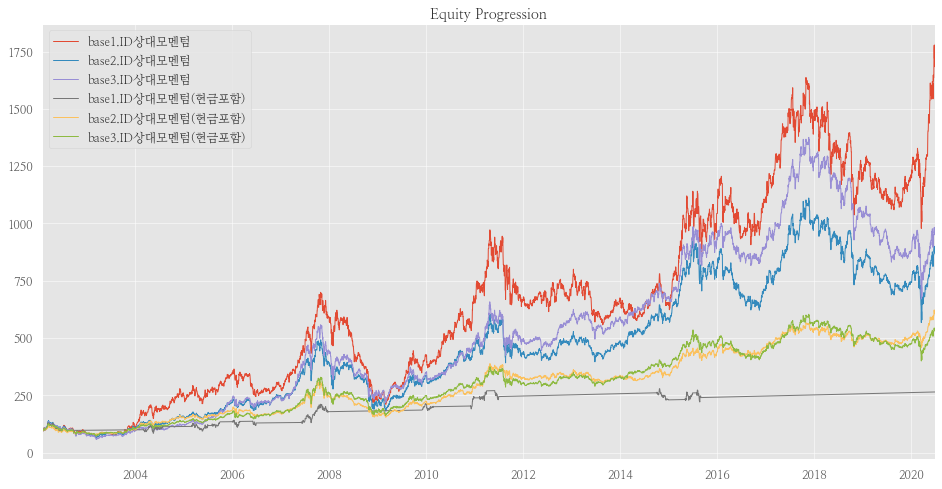

In [23]:
r_all.plot(figsize=(16,8));